**Code to download 4D tiff from the IDR. Works in Colab. Not working in Conda environments**




**package to connect with Image Data Resource** (Takes ~10 minutes to install)

In [ ]:
!pip install -U idr-py


**Import Packages**

In [ ]:
from idr import connection
import numpy
from skimage.io import imshow

**Main code for downloading the image. Update dataset id and image id**

Connected to IDR ...
z:110 t:1 c:1 y:816 x:1636


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


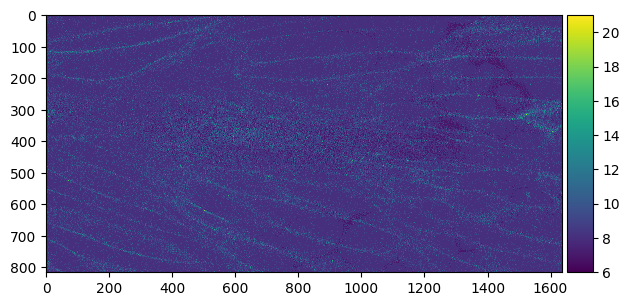

In [ ]:
conn = connection('idr.openmicroscopy.org')

# adapted from https://github.com/ome/omero-guide-ilastik/blob/e9df8014515a8dbbfd87623a24564044d05d2224/notebooks/pixel_classification.ipynb
def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_y = image.getSizeY()
    size_x = image.getSizeX()
    z, t, c = 0, 0, 0  # first plane of the image

    zct_list = []
    for t in range(size_t):
        for z in range(size_z):  # get the Z-stack
            for c in range(size_c):  # all channels
                zct_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    j = 0
    k = 0
    tmp_c = []
    tmp_z = []
    s = "z:%s t:%s c:%s y:%s x:%s" % (size_z, size_t, size_c, size_y, size_x)
    print(s)
    # axis tzyxc
    print("Downloading image %s" % image.getName())
    for i, p in enumerate(planes):
        if k < size_z:
            if j < size_c:
                tmp_c.append(p)
                j = j + 1
            if j == size_c:
                # use dstack to have c at the end
                tmp_z.append(numpy.dstack(tmp_c))
                tmp_c = []
                j = 0
                k = k + 1
        if k == size_z:  # done with the stack
            values.append(numpy.stack(tmp_z))
            tmp_z = []
            k = 0

    return numpy.stack(values)

def retrieve_image(conn, dataset_id, image_id):
    input_data = None

    images = conn.getObjects('Image', opts={'dataset': dataset_id, 'image':image_id})

    for image in images:
        if image.getId() == image_id:
            input_data = load_numpy_array(image)
    return input_data

# see: https://idr.openmicroscopy.org/webclient/?show=image-9844380

# dataset_id :- go to the pagehttps://idr.openmicroscopy.org/webclient/userdata/ to find images. GO to the different subfolders. Click on the sub folder with just images and no subfolder to find the dataset id

dataset_id = 10260
image_id = 9836992

input_data = retrieve_image(conn, dataset_id, image_id)

imshow(input_data[0,0,:,:,0])

**Print the image shape`**

In [ ]:
print(input_data.shape)


(1, 110, 816, 1636, 1)


In [ ]:
input_data_2 = input_data[0,:,:,:,0]

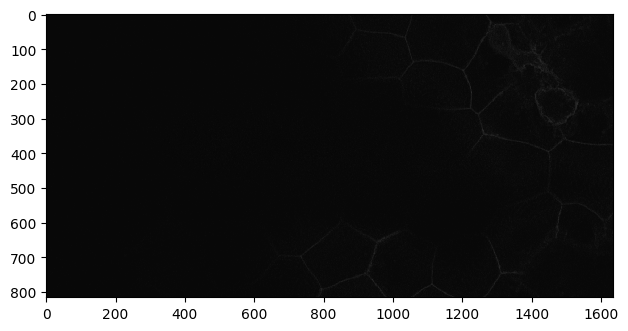

In [ ]:
imshow(input_data_2[108,:,:], cmap='gray')

In [ ]:
print(input_data_2.shape)

(110, 816, 1636)


In [ ]:
from tifffile import imsave, imwrite


In [ ]:
um_to_nm_scaling = 1000


In [ ]:
pixelsize_new = 100

In [ ]:
slice_thickness_new = 220

In [ ]:
# um_to_nm_scaling = 1000
# metadata={'spacing': slice_thickness_new/um_to_nm_scaling, 'unit': 'nm', 'axes': 'ZYX'}
# imwrite("interpolated_image.tif", interpolated_data_16bit, imagej=True,
#        resolution=(1/pixelsize_new*um_to_nm_scaling, 1/pixelsize_new*um_to_nm_scaling), metadata=metadata)


**Saving in drive. For whatever reasons, the x and y resolutions should be mentioned in the format (1./resolution)**

In [ ]:
metadata={'spacing': 0.22, 'unit': 'um', 'axes': 'ZYX'}
imwrite("/content/drive/MyDrive/lat_line_3D_10", input_data_2, imagej=True,
        resolution=(1./0.1, 1./0.1), metadata=metadata)